In [1]:
!date
!python --version

Thu Jun  6 03:20:43 AM UTC 2024
Python 3.10.12


# 特徴的な単語の抽出
ある文書における特徴的な単語とは何だろうか。様々な指標が提案されているが、基本的には (1) 何か特徴を設定し、(2) その重要度を求め、(3) ランキングすることで求める事が多い。最もシンプルなアプローチは (1) 単語毎に、(2) 出現頻度を求め、 (3) 頻出上位を特徴的な単語と捉える方法だ。ここではワードクラウド形式で眺める例と、2文書間の出現頻度分布を眺める例を観察してみよう。

- 参考: [はじめての自然言語処理 第6回 OSS によるテキストマイニング](https://www.ogis-ri.co.jp/otc/hiroba/technical/similar-document-search/part6.html)

## required
- spacy, sklearn
- wordcloud: ``pip install wordcloud``
- scattertext: ``pip install scattertext``

In [2]:
# spacy, ginzaインストール
!pip install -U ginza ja_ginza

!pip install scattertext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 52.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9296 sha256=83ab7688c723f846444e1ec290f63f252f652e8868ba2c2cb4245905f3c04cfe
  Stored in directory: /root/.cache/pip/wheels/bc/be/39/c37ad168eb2ff644c9685f52554440372129450f0b8ed203dd
Successfully built flashtext


## 利用ライブラリの用意、データセット準備
事前に、[load_r_assesment.ipynb](./load_r_assesment.ipynb) でデータセットを作成し、pkl形式でファイル保存(r_assesment.pkl)しておく。今回は作成済みファイルをダウンロードして利用することにする。

r_assesment.pklは授業評価アンケートの自由記述欄をpd.DataFrame形式で保存したもので、授業名(title)、学年(grade)、必修か否か(required)、質問番号(q_id)、コメント(comment)で構成される。

In [3]:
!curl -O https://ie.u-ryukyu.ac.jp/~tnal/2022/dm/static/r_assesment.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34834  100 34834    0     0  16555      0  0:00:02  0:00:02 --:--:-- 16563


In [4]:
import collections

import numpy as np
import pandas as pd
import spacy

nlp = spacy.load("ja_ginza")

assesment_df = pd.read_pickle('r_assesment.pkl')
assesment_df.head()

,title,grade,required,q_id,comment
0,工業数学Ⅰ,1,True,Q21 (1),特になし
1,工業数学Ⅰ,1,True,Q21 (2),正直わかりずらい。むだに間があるし。
2,工業数学Ⅰ,1,True,Q21 (2),例題を取り入れて理解しやすくしてほしい。
3,工業数学Ⅰ,1,True,Q21 (2),特になし
4,工業数学Ⅰ,1,True,Q21 (2),スライドに書く文字をもう少しわかりやすくして欲しいです。


## (何故かみんな大好き) ワードクラウド
- 分かち書きした文章を用意し、最大フォントサイズや画像サイズを指定するぐらいで作成可能。
- wordcloudで日本語を扱う場合、フォント指定が必要。OS毎にフォントの場所が異なるので「Windows wordcolud 日本語」のようにググってみよう。

In [5]:
# 分かち書き
assesment_df['wakati'] = ''
for index, comment in enumerate(assesment_df['comment']):
    doc = nlp(comment)
    wakati_words = []
    for token in doc:
        wakati_words.append(token.lemma_)
    wakati_text = ' '.join(wakati_words)
    assesment_df.at[index, 'wakati'] = wakati_text

assesment_df

,title,grade,required,q_id,comment,wakati
0,工業数学Ⅰ,1,True,Q21 (1),特になし,特に なし
1,工業数学Ⅰ,1,True,Q21 (2),正直わかりずらい。むだに間があるし。,正直 わかる ずらい 。 むだ だ 間 が ある し 。
2,工業数学Ⅰ,1,True,Q21 (2),例題を取り入れて理解しやすくしてほしい。,例題 を 取り入れる て 理解 する やすい する て ほしい 。
3,工業数学Ⅰ,1,True,Q21 (2),特になし,特に なし
4,工業数学Ⅰ,1,True,Q21 (2),スライドに書く文字をもう少しわかりやすくして欲しいです。,スライド に 書く 文字 を もう 少し わかる やすい する て 欲しい です 。
...,...,...,...,...,...,...
165,データマイニング,3,False,Q22,課題が難しいものが多く、時間を多くとってもらえたのは非常に良かったですがかなりきつかったです...,課題 が 難しい もの が 多い 、 時間 を 多い とる て もらえる た の は 非常 ...
166,ICT実践英語Ⅰ,3,False,Q22,オンラインなどで顔を合わせてやりたかったです。,オンライン など で 顔 を 合わせる て やる たい た です 。
167,知能情報実験Ⅲ,3,True,Q21 (2),unityの操作方法の説明などを最初に行ってもらえたらもう少しスムーズにできたのではないかと思う。,unity の 操作方法 の 説明 など を 最初 に 行く て もらえる た もう 少し ...
168,知能情報実験Ⅲ,3,True,Q22,それぞれに任せるといった形で進められたものだったのでそれなりに進めやすかったですが、オンライ...,それぞれ に 任せる と いう た 形 で 進める られる た もの だ た の だ それ ...


In [9]:
# フォントのインストールと設定
!apt-get -y install fonts-ipafont-gothic
font_path = '/usr/share/fonts/truetype/fonts-japanese-mincho.ttf'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 8,237 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-gothic all 00303-21ubuntu1 [3,513 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-mincho all 00303-21ubuntu1 [4,724 kB]
Fetched 8,237 kB in 0s (37.2 MB/s)
Selecting previously unselected package fonts-ipafont-gothic.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../fonts-ipafont-gothic_00303-21ubuntu1_all.deb ...
Unpacking fonts-ipafont-gothic (00303-21ubuntu1) ...
Selecting previously unselected package fonts-ipaf

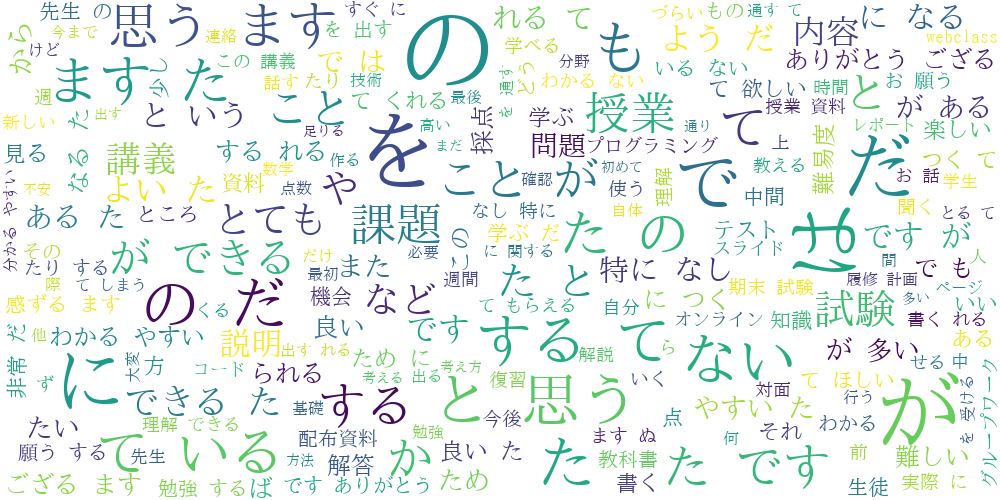

In [10]:
from wordcloud import WordCloud

#font_path = '/Library/Fonts/Arial Unicode' # macOSでデフォルトであると思われるフォント
#wc = WordCloud(background_color='white', font_path=font_path, max_font_size=100, width=1000, height=500).generate(' '.join(assesment_df['wakati']))
wc = WordCloud(background_color='white', font_path=font_path, max_font_size=100, width=1000, height=500).generate(' '.join(assesment_df['wakati']))
wc.to_image()

## scattertextによる2文書の傾向比較
[scattertext](https://github.com/JasonKessler/scattertext)は、2つの文書（もしくは2つの文書集合）の違いを単語出現分布から観察するのに適した可視化ツールだ。対比させるという点が重要であり、そうではないタスク、例えばある文書を要約する（重要語を抽出する）というタスクには向いていない。対比する文書は1文書単位でも良いし、複数文書でも構わない。

なお、3種類以上を同時に比較することはできない。もしそのような場合に用いたいのであれば、例えば「文書1とそれ以外」「文書2とそれ以外」のように one-vs-rest を複数回実行すると良いだろう。

以下では、授業毎のコメント数上位2科目を比較対象とし、以下の手順で描画する。
- 上位2科目の dataframe を用意する。
- コメントの spacy.nlp 解析結果（Doc形式）を用意する。
  - コメント文そのものや分かち書き結果ではなく、Doc型を用意する必要がある。
- dataframe と列を指定して scattertext に処理してもらう。

### 前処理なし

In [11]:
# 授業毎のコメント数上位を確認
assesment_df['title'].value_counts()

title
コンピュータシステム      32
プログラミングⅠ        19
技術者の倫理          18
工業数学Ⅰ           16
アルゴリズムとデータ構造    15
データサイエンス基礎      15
プログラミング演習Ⅰ      13
工学基礎演習          12
プロジェクトデザイン       9
情報ネットワークⅠ        7
情報処理技術概論         7
知能情報実験Ⅲ          3
ディジタル回路          1
キャリアデザイン         1
データマイニング         1
ICT実践英語Ⅰ         1
Name: count, dtype: int64

In [12]:
# 上位2科目のみの dataframe を用意。
# (1) 比較対象をカテゴリ名として保存している列（以下では new_df['title']）と、
# (2) 処理対象となる文書（以下では new_df['comment']）を保存すること。
title1 = 'コンピュータシステム'
title2 = 'プログラミングⅠ'
condition1 = assesment_df['title'] == title1
condition2 = assesment_df['title'] == title2
new_df = assesment_df[condition1 | condition2].loc[:,['title', 'comment']]

# コメント文の nlp 解析結果を用意し、new_df に新しい列として保存する。
# new_df['doc'] の中は丸括弧付きで分かち書きされているように出力されるが、中身はDoc形式である点に注意。
docs = []
for comment in new_df['comment']:
    doc = nlp(comment)
    docs.append(doc)

new_df['doc'] = docs
new_df.head()

,title,comment,doc
46,プログラミングⅠ,特になし,"(特に, なし)"
47,プログラミングⅠ,たまに説明がないコードがあったりしたので少し戸惑った。いずれはやっていくものではあるが、、、,"(たまに, 説明, が, ない, コード, が, あっ, たり, し, た, の, で, 少..."
48,プログラミングⅠ,できれば、対面を増やして欲しい,"(できれ, ば, 、, 対面, を, 増やし, て, 欲しい)"
49,プログラミングⅠ,特になし,"(特に, なし)"
50,プログラミングⅠ,他人の課題を変更できてしまうのが怖い。,"(他人, の, 課題, を, 変更, でき, て, しまう, の, が, 怖い, 。)"


In [13]:
import scattertext as st

# 用意したdataframeと、比較対象カテゴリを保存している列(title)、Docを保存している列(doc)を指定。
corpus = st.CorpusFromParsedDocuments(new_df, category_col='title', parsed_col='doc').build()

# 上記で用意した corpusと、比較対象したいカテゴリ名（title1, title2）を指定。
html = st.produce_scattertext_explorer(corpus, category=title1, category_name=title1, not_category_name=title2)

# 生成されたHTMLを描画。
from IPython.display import display, HTML
HTML(html)

In [14]:
with open('sample.html', 'w') as f:
    f.write(html)

In [15]:
display(HTML("<br>"))

### 前処理あり
コメント文をそのまま処理してしまうと観察したくない単語（助詞など）が多々現れているため、傾向を掴みづらい結果となってしまった。これまでにも見てきたように品詞を指定して観察するとしよう。このためには、(1) new_df['comment'] に含まれるコメントを事前に分かち書きし、そのタイミングで品詞判定をして不要語を削除する方法と、(2) scattertext側でオプション指定する方法がある。ここでは(2)の方法を眺めてみよう。

scattertext側で品詞指定するには、(a) コメント文そのもの、(b) 解析器(spacy.nlp)、(c) 解析クラスを用意する必要がある。(a) は new_df['comment'] をそのまま用いれば良い。(b)は既に用意している nlp を用いれば良い。(c)については [st.FeatsFromSpacyDoc](https://github.com/JasonKessler/scattertext/blob/master/scattertext/features/FeatsFromSpacyDoc.py) を継承した子クラスを作成し、その中で解析方法を書く必要がある。

- NOTE
    - 先程は処理済みDoc型を利用するため st.CorpusFromParsedDocuments() を利用した。今回はテキストと解析機を渡して scattertext 内部で処理するため、st.CorpusFromPandas() を利用している。

In [16]:
class SelectPOS(st.FeatsFromSpacyDoc):
    '''小クラス。
    get_feats() で解析方法を指定する。
    '''
    poses = ['PRPON', 'NOUN', 'VERB', 'ADJ', 'ADV']
    def __init__(self, use_pos=poses):
        super().__init__()
        self._use_pos = use_pos

    def get_feats(self, doc):
        return collections.Counter([c.lemma_ for c in doc if c.pos_ in self._use_pos])

corpus = st.CorpusFromPandas(new_df, category_col='title', text_col='comment', nlp=nlp, feats_from_spacy_doc=SelectPOS()).build()
html = st.produce_scattertext_explorer(corpus, category=title1, category_name=title1, not_category_name=title2)
HTML(html)